In [1]:
import sys
import os
import torchvision.transforms as transforms
from torchvision.transforms import Compose
import torchxrayvision as xrv
import torchvision
import torchvision.io as io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as F
from torch.utils.data.dataloader import default_collate
import pandas as pd

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

%matplotlib inline

In [2]:
bbox_df = pd.read_csv('CXR8/BBox_List_2017.csv', index_col=['Image Index', 'Finding Label'])


In [3]:
bbox_df.head()

x           y           w           h
Image Index      Finding Label                                                
00013118_008.png Atelectasis    225.084746  547.019217   86.779661   79.186441
00014716_007.png Atelectasis    686.101695  131.543498  185.491525  313.491525
00029817_009.png Atelectasis    221.830508  317.053115  155.118644  216.949153
00014687_001.png Atelectasis    726.237288  494.951420  141.016949   55.322034
00017877_001.png Atelectasis    660.067797  569.780787  200.677966   78.101695

In [4]:
columns = [
    "FileName",
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
]

disease_filter = "Atelectasis"

In [5]:
model_xrv = xrv.models.DenseNet(weights="densenet121-res224-all")
model_xrv.eval()

XRV-DenseNet121-densenet121-res224-all

In [6]:
disease_dict = {}
for i in range(len(model_xrv.targets)):
    disease_dict[model_xrv.targets[i]] = i

In [7]:
disease_dict

{'Atelectasis': 0,
 'Consolidation': 1,
 'Infiltration': 2,
 'Pneumothorax': 3,
 'Edema': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Effusion': 7,
 'Pneumonia': 8,
 'Pleural_Thickening': 9,
 'Cardiomegaly': 10,
 'Nodule': 11,
 'Mass': 12,
 'Hernia': 13,
 'Lung Lesion': 14,
 'Fracture': 15,
 'Lung Opacity': 16,
 'Enlarged Cardiomediastinum': 17}

In [7]:
class CXR8Loader(Dataset):
    def __init__(self, data_file, img_dir, transforms = None, target_transforms = None, filter_disease = None):
        self.img_dir = img_dir
        self.data = pd.read_csv(data_file, index_col='FileName', usecols=columns)
        self.transforms = transforms
        self.target_transforms = target_transforms
        self.filter_disease = filter_disease
        if self.filter_disease:
            self.data = self.data[self.data[filter_disease] == 1]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.index[idx])
        image = xrv.utils.load_image(img_path)
        image = image.reshape(image.shape[1], image.shape[2], 1)
        label = self.data.iloc[idx].values
        if self.transforms:
            image = self.transforms(image)
        if self.target_transforms:
            label = self.target_transforms(label)
        return image, label, self.data.index[idx]



In [8]:
transforms_img = Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [9]:
training_data = CXR8Loader(data_file='CXR8/train_label.csv', img_dir='CXR8/images', transforms=transforms_img, filter_disease = None)

In [11]:
len(training_data)

2236

In [10]:
testing_data = CXR8Loader(data_file='CXR8/train_label.csv', img_dir='CXR8/images', transforms=transforms_img, filter_disease = disease_filter)
dataloader = DataLoader(testing_data, batch_size=len(testing_data), shuffle=True)

In [23]:
model_xrv.features[-2][-1][-1]

Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [13]:
model_xrv.features[-1]

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [11]:
# target_layers = [model_xrv.features[-2][-1][-1]] # last conv layer of the last dense block
target_layers = [model_xrv.features[-2][-1][-1]]
cam = GradCAM(model=model_xrv, target_layers=target_layers)
targets = [ClassifierOutputSoftmaxTarget(disease_dict[disease_filter])]


In [17]:
from pprint import pprint

sample_idx = torch.randint(len(testing_data), size=(1,)).item()
img, label, name = testing_data[sample_idx]
img = img.unsqueeze(0)
preds = model_xrv(img)
pprint(dict(zip(xrv.datasets.default_pathologies,preds[0].detach().numpy())))

{'Atelectasis': 0.28258,
 'Cardiomegaly': 0.006027558,
 'Consolidation': 0.12457617,
 'Edema': 0.000931413,
 'Effusion': 0.025846753,
 'Emphysema': 0.3736494,
 'Enlarged Cardiomediastinum': 0.023005728,
 'Fibrosis': 0.50932884,
 'Fracture': 0.20234881,
 'Hernia': 0.02542288,
 'Infiltration': 0.26235908,
 'Lung Lesion': 0.00022837285,
 'Lung Opacity': 0.5175775,
 'Mass': 0.50543547,
 'Nodule': 0.51331186,
 'Pleural_Thickening': 0.23461378,
 'Pneumonia': 0.0010869179,
 'Pneumothorax': 0.09878676}


In [14]:
label

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

No bounding box for 00000057_002.png
0.5896472
No bounding box for 00000310_004.png
0.13612798
No bounding box for 00000248_007.png
0.55826175
No bounding box for 00000831_001.png
0.1670941
No bounding box for 00000053_001.png
0.52859926
No bounding box for 00000540_001.png
0.58411217
No bounding box for 00000368_007.png
0.5669128
No bounding box for 00000250_001.png
0.52417666
No bounding box for 00000877_036.png
0.5989071
No bounding box for 00000248_010.png
0.5831485


Text(0.5, 0.98, 'Atelectasis')

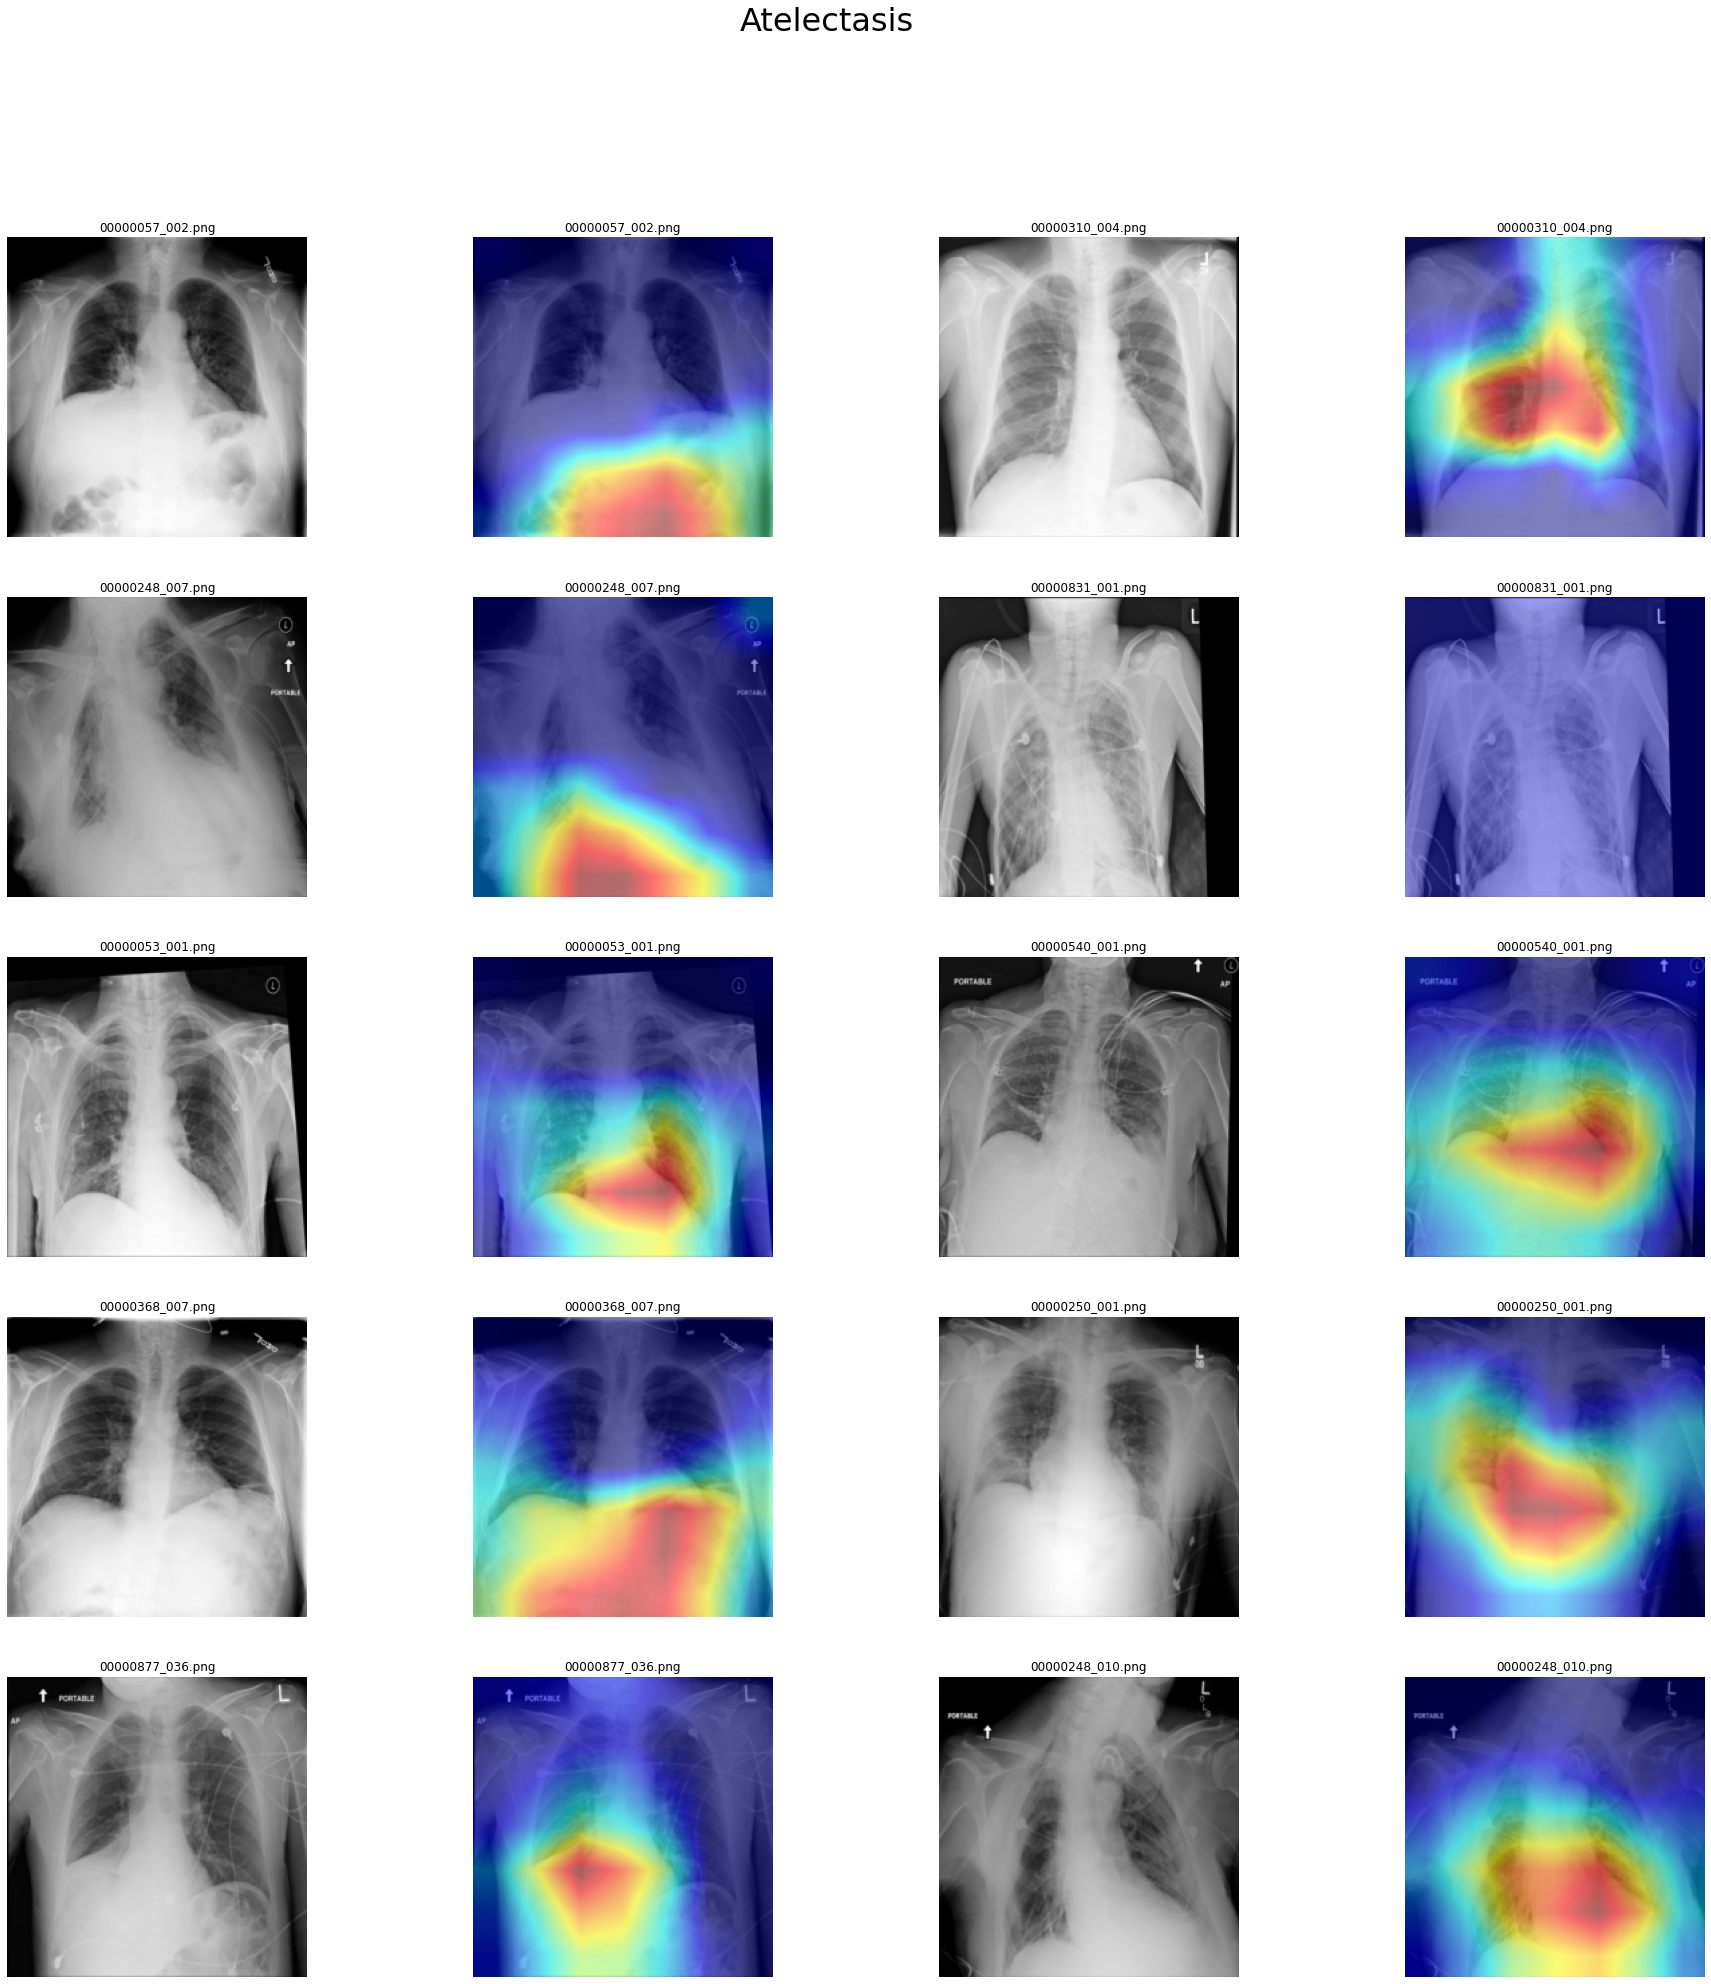

In [12]:
figure = plt.figure(figsize=(32, 32))
cols, rows = 4, 5
for i in range(1, cols * rows + 1, 2):
    sample_idx = torch.randint(len(testing_data), size=(1,)).item()
    img, label, name = testing_data[sample_idx]
    annotated_img = F.to_dtype(img, torch.uint8)
    figure.add_subplot(rows, cols, i)

    try:
        bbox = bbox_df.loc[name, disease_filter].values
        print(f'Bounding box for {name}')
        annotated_img = draw_bounding_boxes(img.squeeze(), bbox, colors="yellow", width=3)
        plt.imshow(annotated_img, cmap="gray")
    except KeyError:
        print(f'No bounding box for {name}')
        plt.imshow(img.squeeze(), cmap="gray")
    plt.title(name)
    plt.axis("off")
    # break
    img = img.unsqueeze(0)
    preds = model_xrv(img)
    print(dict(zip(xrv.datasets.default_pathologies,preds[0].detach().numpy()))[disease_filter])
    image_np = img.numpy()
    image_np = image_np - np.min(image_np)
    image_np = image_np / np.max(image_np)
    image_np = np.transpose(image_np, (0, 2, 3, 1))
    figure.add_subplot(rows, cols, i+1)
    grayscale_cam = cam(input_tensor=img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    plt.title(name)
    plt.axis("off")
    plt.imshow(visualization.squeeze(), cmap="jet")
figure.suptitle(disease_filter, fontsize=32)



No bounding box for 00000608_001.png
0.6440661
No bounding box for 00000688_001.png
0.07421889
No bounding box for 00000823_003.png
0.5140733
No bounding box for 00000607_000.png
0.75800294
No bounding box for 00000038_000.png
0.5905788
No bounding box for 00000176_001.png
0.64738464
No bounding box for 00000221_000.png
0.6237776
No bounding box for 00000096_001.png
0.8167344
No bounding box for 00000448_000.png
0.6913703
No bounding box for 00000096_001.png
0.8167344


Text(0.5, 0.98, 'Cardiomegaly')

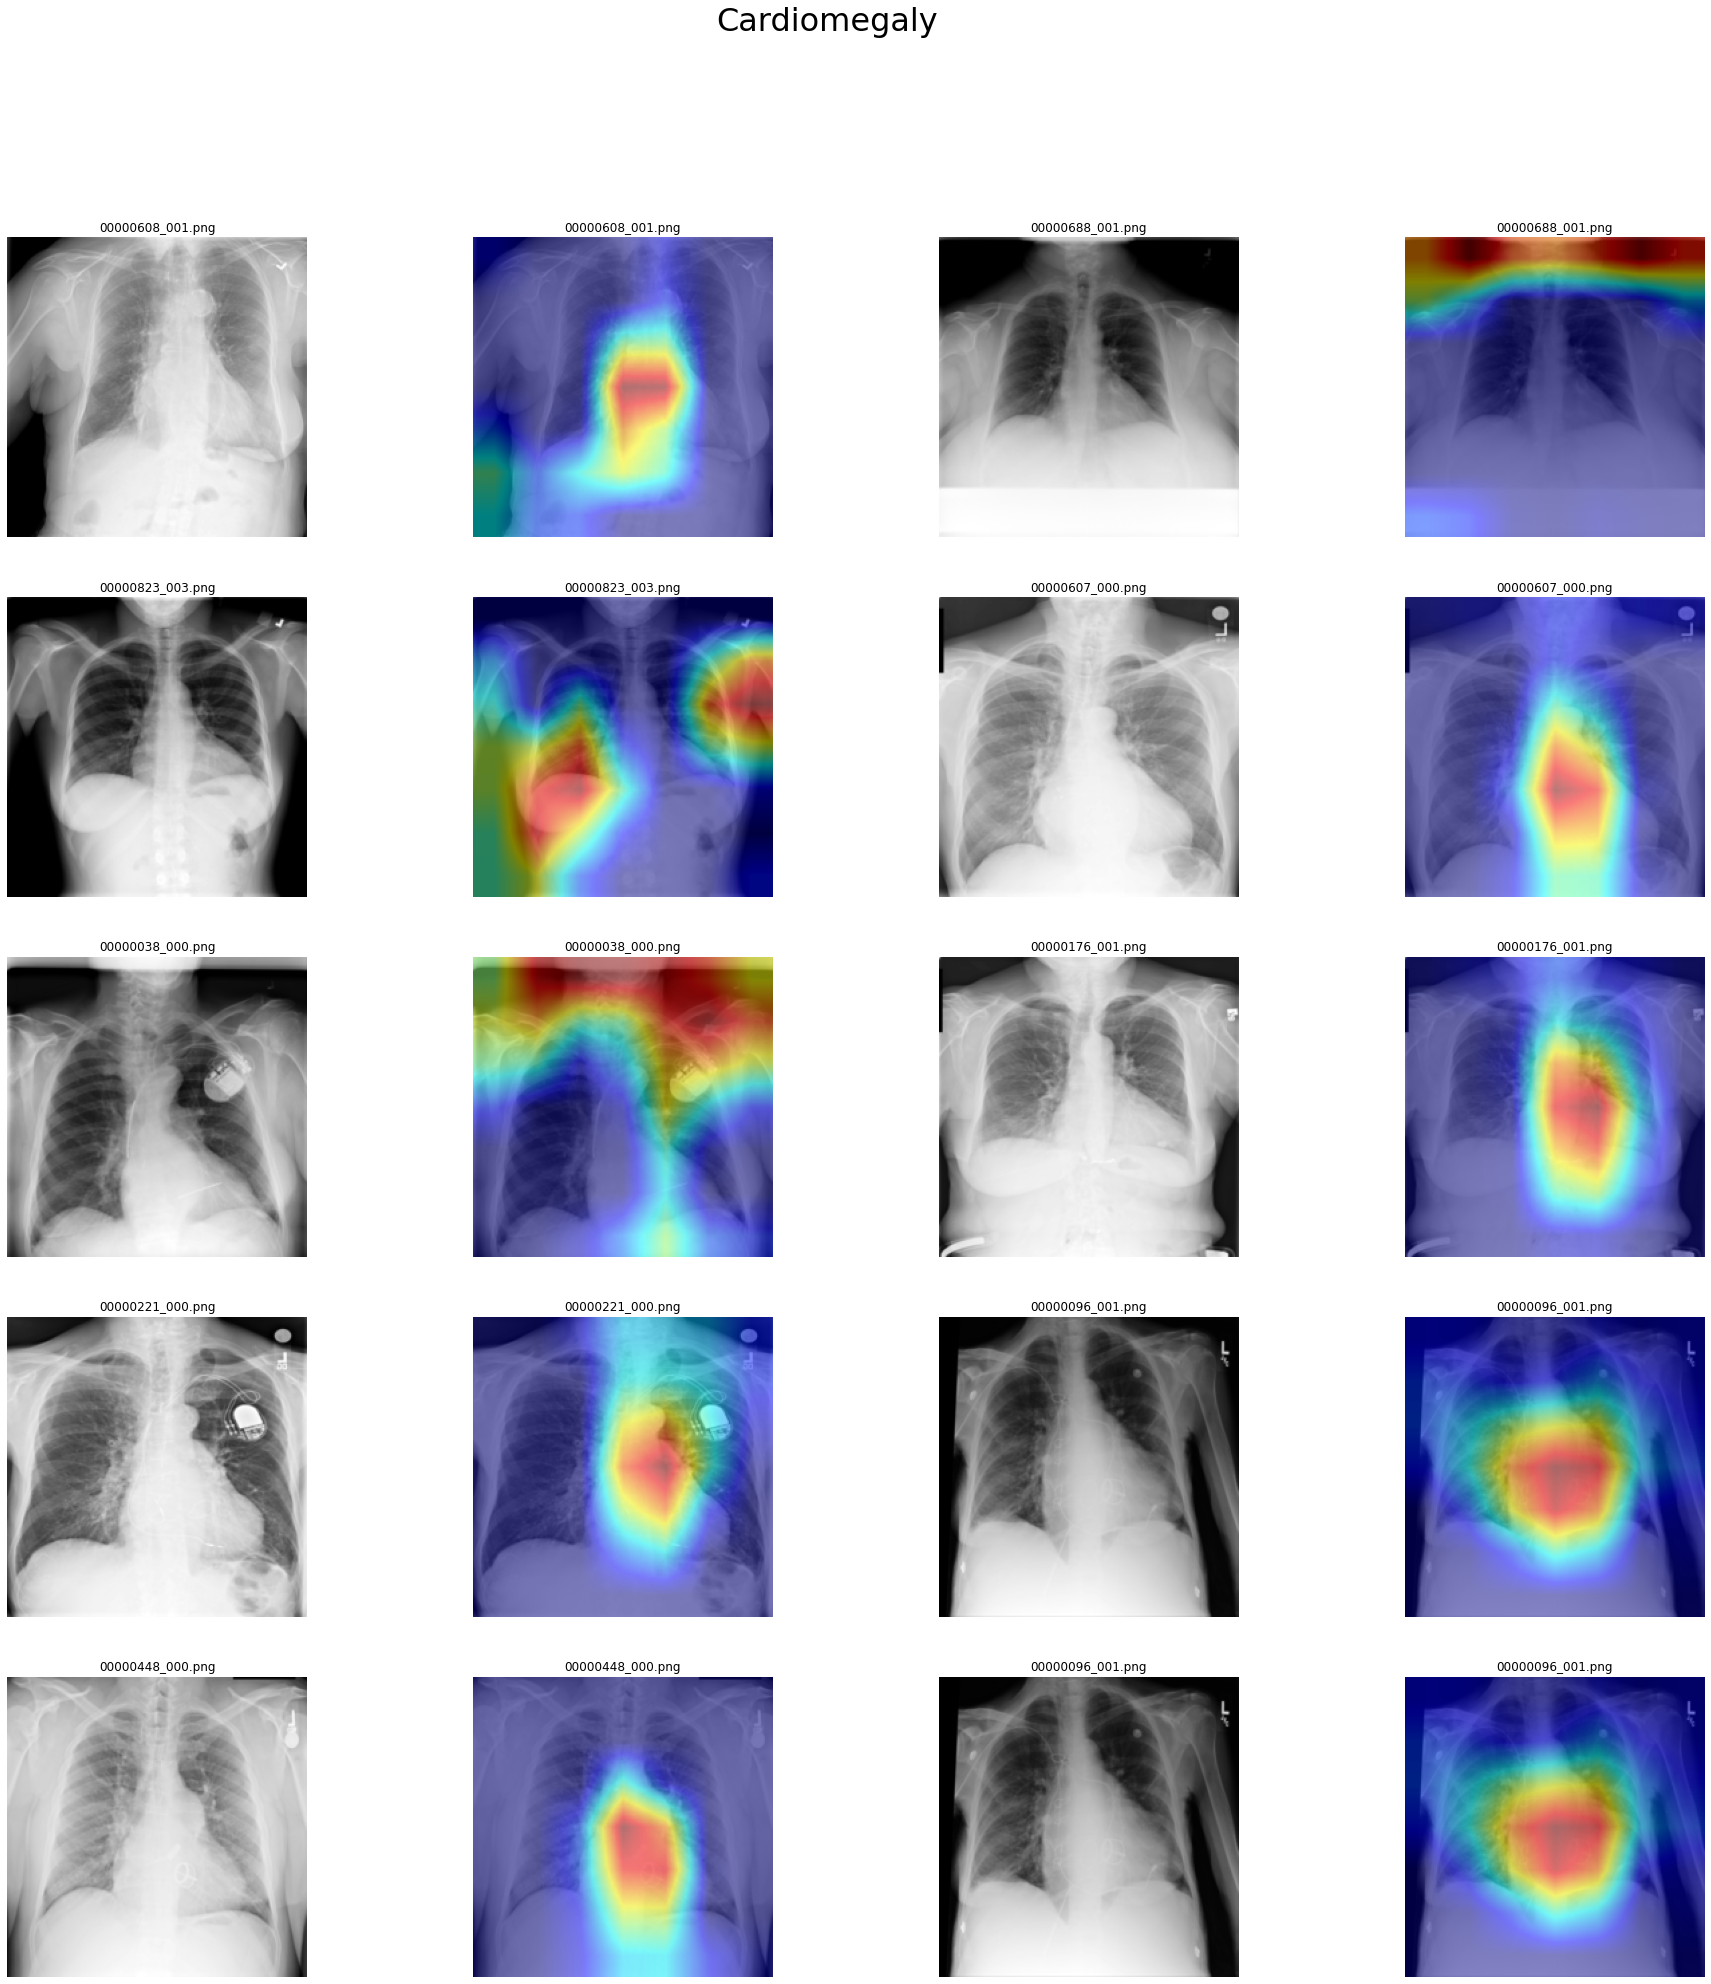

In [16]:
figure = plt.figure(figsize=(32, 32))
cols, rows = 4, 5
for i in range(1, cols * rows + 1, 2):
    sample_idx = torch.randint(len(testing_data), size=(1,)).item()
    img, label, name = testing_data[sample_idx]
    annotated_img = F.to_dtype(img, torch.uint8)
    figure.add_subplot(rows, cols, i)

    try:
        bbox = bbox_df.loc[name, disease_filter].values
        print(f'Bounding box for {name}')
        annotated_img = draw_bounding_boxes(img.squeeze(), bbox, colors="yellow", width=3)
        plt.imshow(annotated_img, cmap="gray")
    except KeyError:
        print(f'No bounding box for {name}')
        plt.imshow(img.squeeze(), cmap="gray")
    plt.title(name)
    plt.axis("off")
    # break
    img = img.unsqueeze(0)
    preds = model_xrv(img)
    print(dict(zip(xrv.datasets.default_pathologies,preds[0].detach().numpy()))[disease_filter])
    image_np = img.numpy()
    image_np = image_np - np.min(image_np)
    image_np = image_np / np.max(image_np)
    image_np = np.transpose(image_np, (0, 2, 3, 1))
    figure.add_subplot(rows, cols, i+1)
    grayscale_cam = cam(input_tensor=img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    plt.title(name)
    plt.axis("off")
    plt.imshow(visualization.squeeze(), cmap="jet")
figure.suptitle(disease_filter, fontsize=32)



In [9]:
data_file = 'CXR8/train_label.csv'
img_dir = 'CXR8/images'

data = pd.read_csv(data_file, index_col='FileName', usecols=columns)
data = data[data[disease_filter] == 1]
data.head()


Atelectasis  Cardiomegaly  Effusion  Infiltration  Mass  \
FileName                                                                    
00000056_000.png            0             0         0             0     0   
00000061_012.png            0             0         1             1     0   
00000061_015.png            0             0         0             0     0   
00000144_001.png            0             0         0             0     0   
00000165_001.png            0             0         0             0     0   

                  Nodule  Pneumonia  Pneumothorax  Consolidation  Edema  \
FileName                                                                  
00000056_000.png       1          1             0              0      0   
00000061_012.png       0          1             0              0      1   
00000061_015.png       0          1             0              0      0   
00000144_001.png       0          1             0              0      0   
00000165_001.png       0          1             0              0      0   

                  Emphysema  Fibrosis  Pleural_Thickening  Hernia  
FileName                                                           
00000056_000.png          0         0                   0       0  
00000061_012.png          0         0                   1       0  
00000061_015.png          0         0                   0       0  
00000144_001.png          0         0                   0       0  
00000165_001.png          0         0                   0       0

In [12]:
bbox_df = pd.read_csv('CXR8/BBox_List_2017.csv')

In [15]:
path = os.path.join(img_dir, bbox_df.iloc[0]['Image Index'])

In [94]:
image = xrv.utils.load_image(path)
image = image[None, :, :, :]
image.shape

(1, 1, 1024, 1024)

In [95]:
image_np = image - np.min(image)
image_np = image_np / np.max(image_np)

In [96]:
# numpy to torch tensor
image = torch.from_numpy(image)

In [97]:
image_np.shape

(1, 1, 1024, 1024)

In [98]:
image_np = image_np[0].reshape(image_np.shape[2], image_np.shape[3], 1).shape

In [ ]:
grayscale_cam = cam(input_tensor=image, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

In [48]:
x, y, w, h = bbox_df.iloc[0, 2:].values

In [58]:
image = F.to_dtype(image, torch.uint8)

In [67]:
bbox = torchvision.ops.box_convert(torch.Tensor([[x, y, w, h]]), 'xywh', 'xyxy')

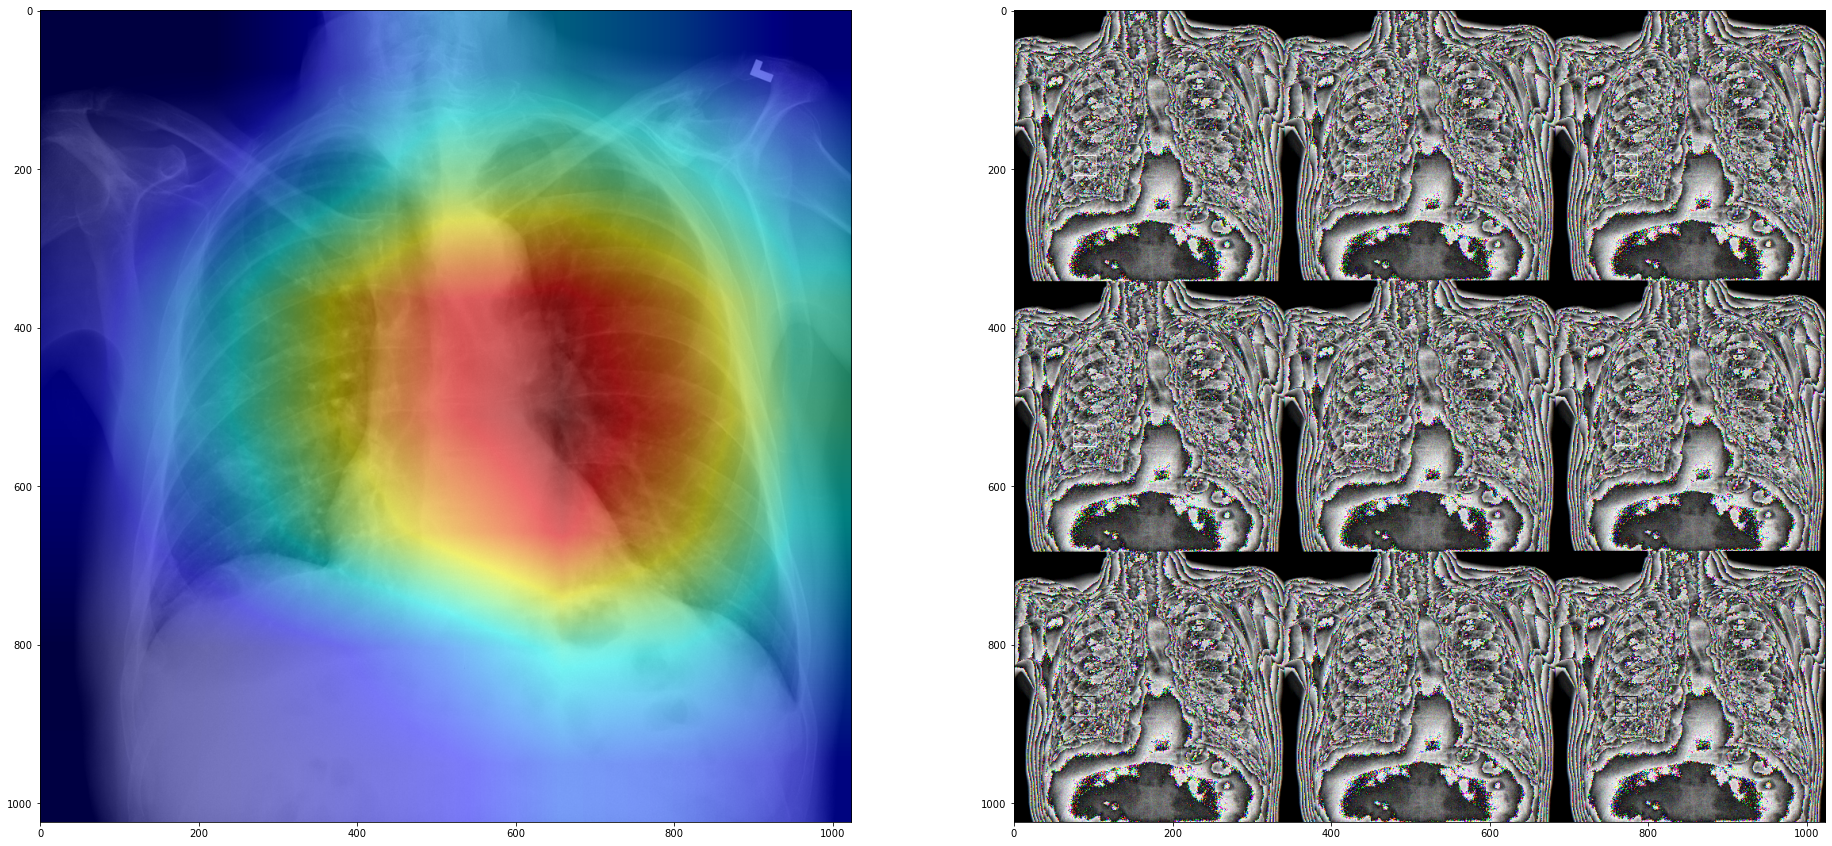

In [71]:
figure = plt.figure(figsize=(32, 32))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.imshow(visualization.squeeze(), cmap="jet")
figure.add_subplot(rows, cols, 2)
plt.imshow(img.reshape(img.shape[1], img.shape[2], 3), cmap="gray")

In [1]:
d = 5
s=0
i=1

while i<=d:
    s=s+i
    i+=1
    print(s)

1
3
6
10
15
